In [1]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

ModuleNotFoundError: No module named 'ds'

In [61]:
# ct_dir = '../../datasets/108/CT'
ct_dir = '../../datasets/multimodal_slices/ct'
# pet_dir = '../../datasets/108/PET'
pet_dir = '../../datasets/multimodal_slices/pet'
test_split_dir = '../../datasets/test_split.txt'

test_flist = []

NUM_TRAINING = 4000
NUM_VALIDATING = 500
NUM_TESTING = 500

# for i in range(NUM_TESTING):
#    test_flist.append('{}.npy'.format(NUM_TRAINING + NUM_VALIDATING + i))

with open(test_split_dir, 'r') as f:
    test_flist = f.read().split('\n')

test_flist = test_flist[:-1]

test_loader = PETnCTDataset(pet_dir, ct_dir, test_flist, test_flist, do_aug=False)

In [62]:
def unscale_image(scaled_image: np.array, original_range: list, scaled_range:list =[0, 1]):
    minmax_form = (scaled_image - scaled_range[0]) / (scaled_range[1] - scaled_range[0])
    original_image = minmax_form * (original_range[1] - original_range[0]) + original_range[0]

    return original_image

torch.Size([1, 128, 128])


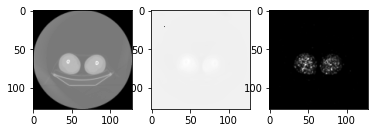

SSIM: 0.5661673182570572
PSNR: 24.184766842087978
MAE: 0.017268988081667852
torch.Size([1, 128, 128])


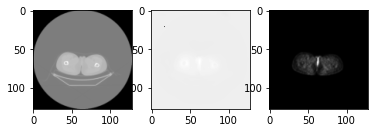

SSIM: 0.6371555119336365
PSNR: 25.74253918068694
MAE: 0.015535712171970525
torch.Size([1, 128, 128])


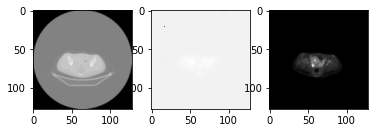

SSIM: 0.7937135754210356
PSNR: 23.959264914192097
MAE: 0.015652042837282075
torch.Size([1, 128, 128])


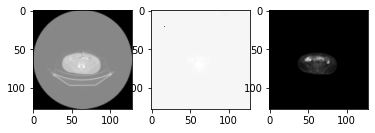

SSIM: 0.8885659140434572
PSNR: 23.392526225903055
MAE: 0.013489234084470446
torch.Size([1, 128, 128])


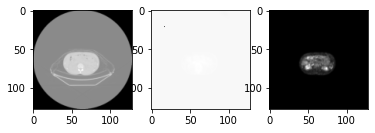

SSIM: 0.8960314887174323
PSNR: 20.951333082726592
MAE: 0.019062547736659104
torch.Size([1, 128, 128])


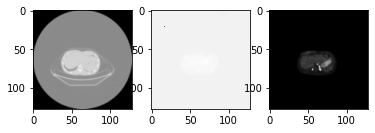

SSIM: 0.9251481973333698
PSNR: 25.03878112575448
MAE: 0.008432455566919747
torch.Size([1, 128, 128])


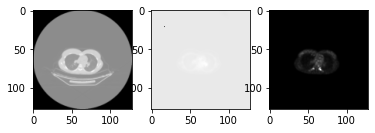

SSIM: 0.9259425556533883
PSNR: 26.211877244418034
MAE: 0.006548599801370651
torch.Size([1, 128, 128])


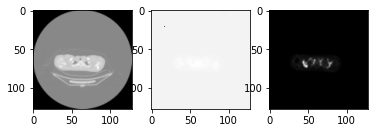

SSIM: 0.9272010149683191
PSNR: 25.2354248286913
MAE: 0.006672322960685628
torch.Size([1, 128, 128])


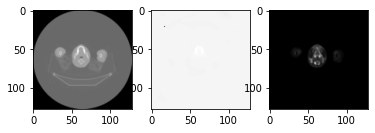

SSIM: 0.807135988057986
PSNR: 25.71316706776097
MAE: 0.01184086853770265
torch.Size([1, 128, 128])


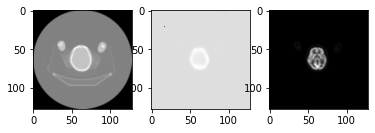

SSIM: 0.8982254329352434
PSNR: 25.729137712337007
MAE: 0.008779128072174167
Avg SSIM: 0.8265286997320926
Avg PSNR: 24.615881822455844


In [63]:
netG_A = CasUNet_3head(1,1)
netG_A.load_state_dict(torch.load('../ckpt/I2I_CasUNet3headGAN_G_1_0.0001_best.pth'))
netG_A.type(torch.FloatTensor)
netG_A.eval()

DISPLAY_OFFSET = 30
# DISPLAY_OFFSET = 1

test_nsample = 10
# test_nsample = len(test_loader)

ssim_avg = 0
psnr_avg = 0

for i in range(test_nsample):
    test_data = test_loader[i * DISPLAY_OFFSET]
    
    pet_img, ct_img = test_data['pet'], test_data['ct']
    pet_min, pet_max = test_data['pet_min'], test_data['pet_max']
    ct_min, ct_max = test_data['ct_min'], test_data['ct_max']

    ct_img = ct_img.type(torch.FloatTensor)

    with torch.no_grad():
        pred_img, _, _ = netG_A(ct_img)

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        print(pred_img.shape)

        ssim_score = ssim(pet_img.numpy().transpose([1, 2, 0]),
                      pred_img.numpy().transpose([1, 2, 0]), channel_axis=-1,
                      data_range=1)

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        psnr_score = psnr(pet_img.numpy(), pred_img.numpy(), data_range=1)

        mae = compute_mae(pred_img.numpy(), pet_img.numpy())

        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(ct_img, cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(pred_img, cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(pet_img, cmap='gray')
        plt.show()

        print('SSIM: {}'.format(ssim_score))
        print('PSNR: {}'.format(psnr_score))
        print('MAE: {}'.format(mae))

        ssim_avg += ssim_score
        psnr_avg += psnr_score

ssim_avg /= test_nsample
psnr_avg /= test_nsample

print('Avg SSIM: {}'.format(ssim_avg))
print('Avg PSNR: {}'.format(psnr_avg))

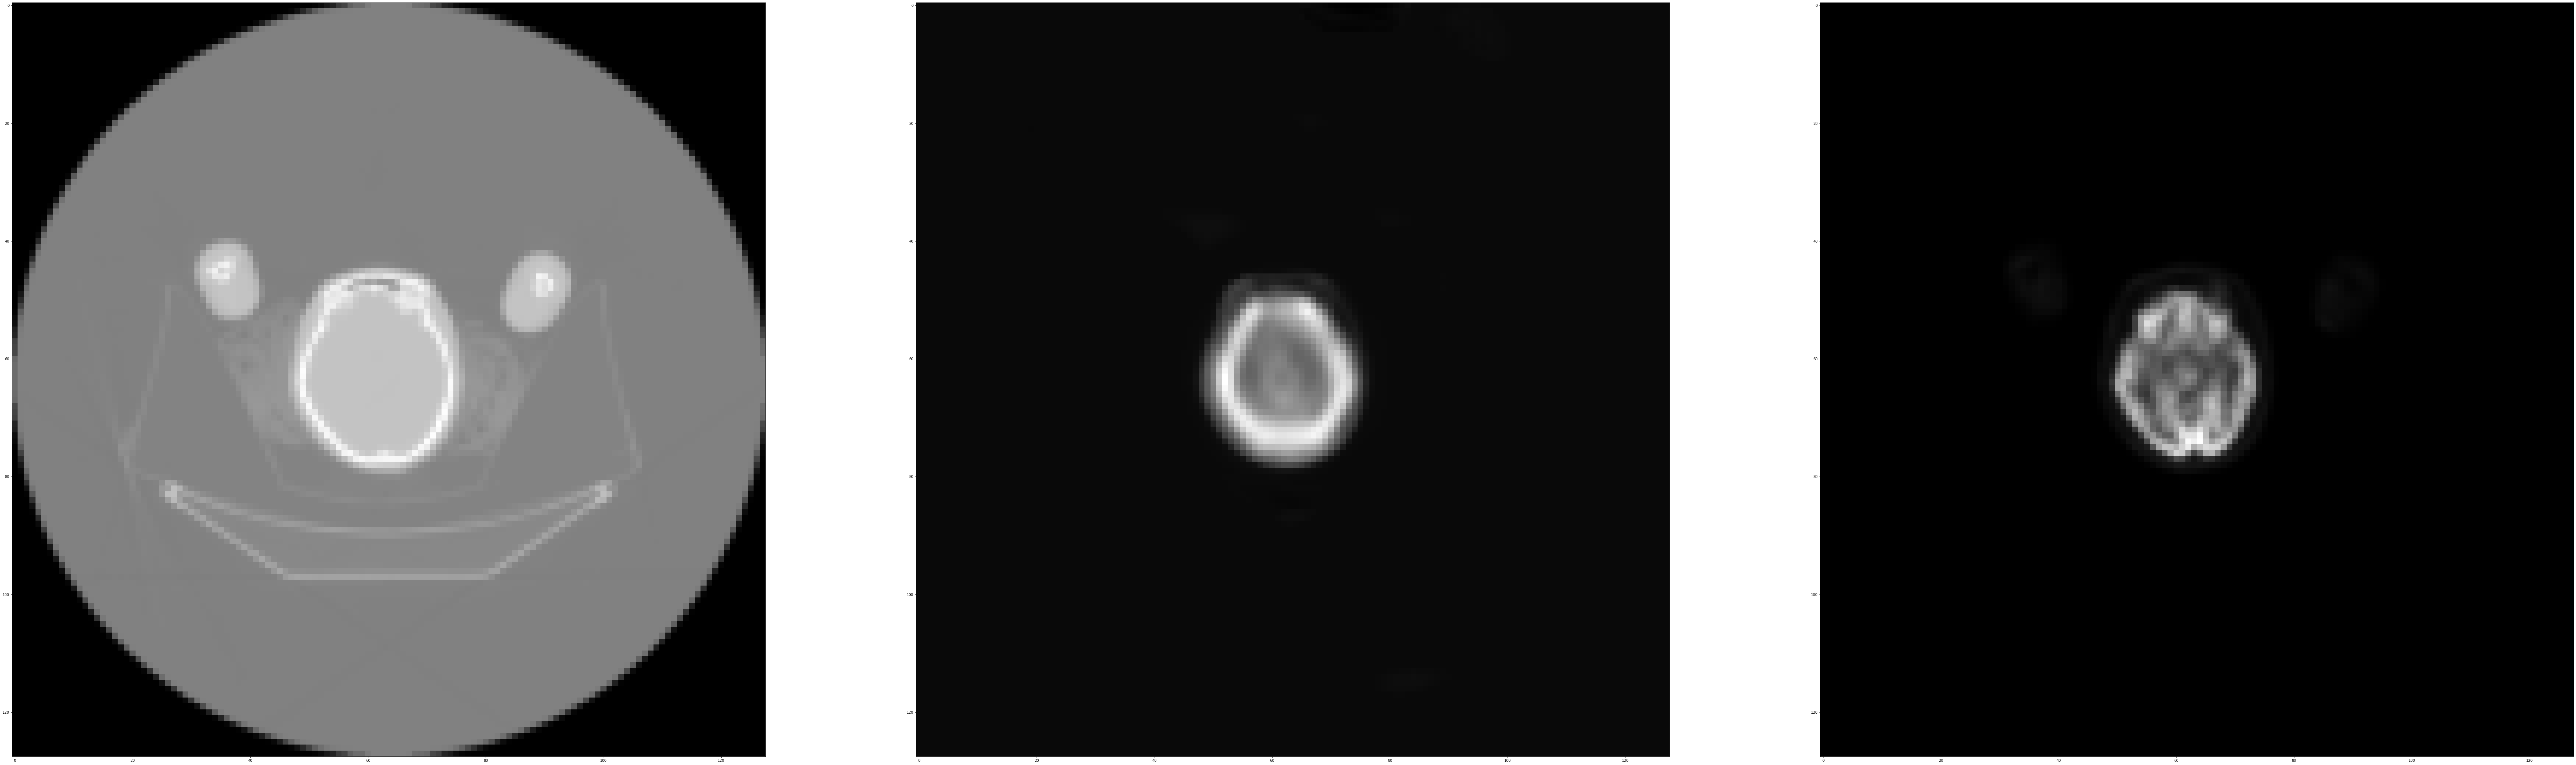

SSIM: 0.9499881781150189
PSNR: 29.35913686807053
Avg SSIM: 0.9499881781150189
Avg PSNR: 29.35913686807053


In [64]:
netG_A1 = CasUNet_3head(1,1)
netG_A1.load_state_dict(torch.load('../ckpt/I2I_CasUNet3headGAN_G_1_0.0001_best.pth'))
netG_A1.type(torch.FloatTensor)
netG_A1.eval()

netG_A2 = UNet_3head(4,1)
netG_A2.load_state_dict(torch.load('../ckpt/I2I_Sequence_CasUNet3headGAN_Block2_G_0.5_0.001_best.pth'))
netG_A2.type(torch.FloatTensor)
netG_A2.eval()

list_netG_A = [netG_A1, netG_A2]

DISPLAY_OFFSET = 267
# DISPLAY_OFFSET = 1

test_nsample = 1
# test_nsample = len(test_loader)

ssim_avg = 0
psnr_avg = 0

for i in range(test_nsample):
    test_data = test_loader[(i + 1) * DISPLAY_OFFSET]

    pet_img, ct_img = test_data['pet'], test_data['ct']
    pet_min, pet_max = test_data['pet_min'], test_data['pet_max']
    ct_min, ct_max = test_data['ct_min'], test_data['ct_max']

    ct_img = ct_img.type(torch.FloatTensor)

    for nid, netG in enumerate(list_netG_A):
        if nid == 0:
            rec_B, rec_alpha_B, rec_beta_B = netG(ct_img)
        else:
            xch = torch.cat([rec_B, rec_alpha_B, rec_beta_B, ct_img], dim=1)
            rec_B, rec_alpha_B, rec_beta_B = netG(xch)

    with torch.no_grad():
        pred_img = rec_B

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        ssim_score = ssim(pet_img.numpy().transpose([1, 2, 0]),
                      pred_img.numpy().transpose([1, 2, 0]), channel_axis=-1,
                      data_range=1)

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        psnr_score = psnr(pet_img.numpy(), pred_img.numpy(), data_range=1)

        mae = compute_mae(pred_img.numpy(), pet_img.numpy())

        plt.figure(figsize=(128, 128))
        plt.subplot(1,3,1)
        plt.imshow(ct_img, cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(pred_img, cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(pet_img, cmap='gray')
        plt.show()

        print('SSIM: {}'.format(ssim_score))
        print('PSNR: {}'.format(psnr_score))

        ssim_avg += ssim_score
        psnr_avg += psnr_score

ssim_avg /= test_nsample
psnr_avg /= test_nsample

print('Avg SSIM: {}'.format(ssim_avg))
print('Avg PSNR: {}'.format(psnr_avg))

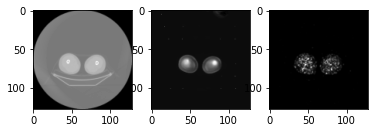

SSIM: 0.8740009433004791
PSNR: 24.945681136722506


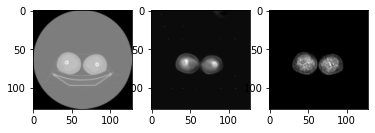

SSIM: 0.8648302593920199
PSNR: 20.027647156578062


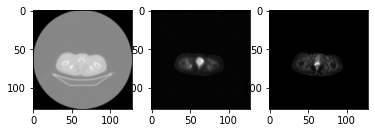

SSIM: 0.9193352118387859
PSNR: 30.459873572548087


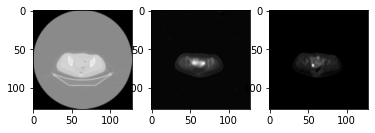

SSIM: 0.9406964059860004
PSNR: 32.170236866638035


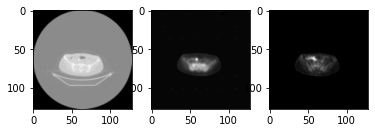

SSIM: 0.9425660308275148
PSNR: 29.818556440787805


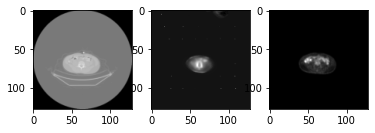

SSIM: 0.8982782321062368
PSNR: 23.492115434341066


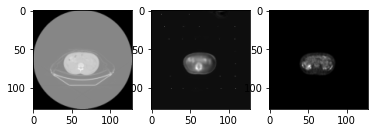

SSIM: 0.9094233155886897
PSNR: 24.591109552140633


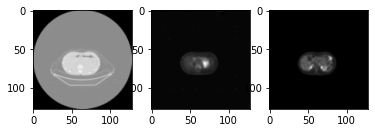

SSIM: 0.9144541908206895
PSNR: 25.353705419573096


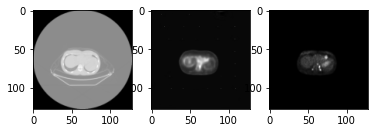

SSIM: 0.9367348312430979
PSNR: 29.099650111006095


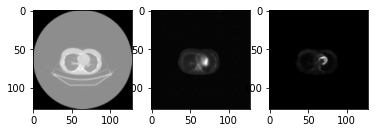

SSIM: 0.9546532583108143
PSNR: 31.515091248293547
SSIM: 0.9154972679414328
PSNR: 27.147366693862892
MAE: 0.011039979804956355


In [65]:
netG_A1 = CasUNet_3head(1,1)
netG_A1.load_state_dict(torch.load('../ckpt/I2I_CasUNet3headGAN_G_1_0.0001_best.pth'))
netG_A1.type(torch.FloatTensor)
netG_A1.eval()

netG_A2 = UNet_3head(4,1)
netG_A2.load_state_dict(torch.load('../ckpt/I2I_Sequence_CasUNet3headGAN_Block2_G_0.5_0.001_best.pth'))
netG_A2.type(torch.FloatTensor)
netG_A2.eval()

netG_A3 = UNet_3head(4,1)
netG_A3.load_state_dict(torch.load('../ckpt/I2I_Sequence_CasUNet3headGAN_Block3_G_0.1_0.01_best.pth'))
netG_A3.type(torch.FloatTensor)
netG_A3.eval()

list_netG_A = [netG_A1, netG_A2, netG_A3]

DISPLAY_OFFSET = 19
# DISPLAY_OFFSET = 1

test_nsample = 10
# test_nsample = len(test_loader)

ssim_avg = 0
psnr_avg = 0
mae_avg = 0

for i in range(test_nsample):
    test_data = test_loader[i * DISPLAY_OFFSET]

    pet_img, ct_img = test_data['pet'], test_data['ct']
    pet_min, pet_max = test_data['pet_min'], test_data['pet_max']
    ct_min, ct_max = test_data['ct_min'], test_data['ct_max']

    ct_img = ct_img.type(torch.FloatTensor)

    for nid, netG in enumerate(list_netG_A):
        if nid == 0:
            rec_B, rec_alpha_B, rec_beta_B = netG(ct_img)
        else:
            xch = torch.cat([rec_B, rec_alpha_B, rec_beta_B, ct_img], dim=1)
            rec_B, rec_alpha_B, rec_beta_B = netG(xch)

    with torch.no_grad():
        pred_img = rec_B

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        ssim_score = ssim(pet_img.numpy().transpose([1, 2, 0]),
                      pred_img.numpy().transpose([1, 2, 0]), channel_axis=-1,
                      data_range=1)

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        psnr_score = psnr(pet_img.numpy(), pred_img.numpy(), data_range=1)

        mae = compute_mae(pred_img.numpy(), pet_img.numpy())

        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(ct_img, cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(pred_img, cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(pet_img, cmap='gray')
        plt.show()

        print('SSIM: {}'.format(ssim_score))
        print('PSNR: {}'.format(psnr_score))

        ssim_avg += ssim_score
        psnr_avg += psnr_score
        mae_avg += mae

ssim_avg /= test_nsample
psnr_avg /= test_nsample
mae_avg /= test_nsample

print('SSIM: {}'.format(ssim_avg))
print('PSNR: {}'.format(psnr_avg))
print('MAE: {}'.format(mae_avg))